# Lesson 5: Supervised Machine Learning

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

### CSV

We will use the Kaggle Food Demand Forecasting data to demonstrate these major steps.
- Data: https://www.kaggle.com/datasets/kannanaikkal/food-demand-forecasting/

In [2]:
# Import data from Kaggle Competition
PATH = "../../data/food_demand"
train_data = pd.read_csv(os.path.join(PATH, "train.csv"), index_col=0)
test_data = pd.read_csv(os.path.join(PATH, "test.csv"), index_col=0)

train_data.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
id,,,,,,,,
1379560,1,55,1885,136.83,152.29,0,0,177
1466964,1,55,1993,136.83,135.83,0,0,270
1346989,1,55,2539,134.86,135.86,0,0,189
1338232,1,55,2139,339.50,437.53,0,0,54
1448490,1,55,2631,243.50,242.50,0,0,40


In [3]:
train_data.tail()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
id,,,,,,,,
1271326,145,61,1543,484.09,484.09,0,0,68
1062036,145,61,2304,482.09,482.09,0,0,42
1110849,145,61,2664,237.68,321.07,0,0,501
1147725,145,61,2569,243.50,313.34,0,0,729
1361984,145,61,2490,292.03,290.03,0,0,162


In [4]:
test_data.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
id,,,,,,,
1028232,146,55,1885,158.11,159.11,0,0
1127204,146,55,1993,160.11,159.11,0,0
1212707,146,55,2539,157.14,159.14,0,0
1082698,146,55,2631,162.02,162.02,0,0
1400926,146,55,1248,163.93,163.93,0,0


In [5]:
meal_info_df = pd.read_csv(os.path.join(PATH, "meal_info.csv"), index_col=0)
meal_info_df = meal_info_df.reset_index(drop=False)
meal_info_df.tail()

,meal_id,category,cuisine
46,2956,Fish,Continental
47,2104,Fish,Continental
48,2444,Seafood,Continental
49,2867,Seafood,Continental
50,1445,Seafood,Continental


In [6]:
meal_info_df[["category", "meal_id"]].groupby(["category"]).count()

,meal_id
category,
Beverages,12
Biryani,3
Desert,3
Extras,3
Fish,3
Other Snacks,3
Pasta,3
Pizza,3
Rice Bowl,3


In [7]:
train_data = train_data.merge(meal_info_df, on='meal_id', how='left')

In [8]:
train_data[["category", "meal_id"]].groupby(["category"]).count().sort_values(by='meal_id', ascending=False)

,meal_id
category,
Beverages,127890
Rice Bowl,33408
Sandwich,33291
Pizza,33138
Starters,29941
Other Snacks,29379
Desert,29294
Salad,28559
Pasta,27694


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   week                   456548 non-null  int64  
 1   center_id              456548 non-null  int64  
 2   meal_id                456548 non-null  int64  
 3   checkout_price         456548 non-null  float64
 4   base_price             456548 non-null  float64
 5   emailer_for_promotion  456548 non-null  int64  
 6   homepage_featured      456548 non-null  int64  
 7   num_orders             456548 non-null  int64  
 8   category               456548 non-null  object 
 9   cuisine                456548 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 34.8+ MB


In [10]:
for i in range(146):
    slice = train_data[train_data["week"] == i]
    length = len(slice)
    unique_ids = len(slice["meal_id"].unique())
    if length != unique_ids:
        print(f"Week {i} has more than one entry per meal_id. {length=}, {unique_ids=}")

Week 1 has more than one entry per meal_id. length=2922, unique_ids=45
Week 2 has more than one entry per meal_id. length=2896, unique_ids=45
Week 3 has more than one entry per meal_id. length=2899, unique_ids=45
Week 4 has more than one entry per meal_id. length=2889, unique_ids=45
Week 5 has more than one entry per meal_id. length=2859, unique_ids=45
Week 6 has more than one entry per meal_id. length=2846, unique_ids=45
Week 7 has more than one entry per meal_id. length=2795, unique_ids=45
Week 8 has more than one entry per meal_id. length=2786, unique_ids=45
Week 9 has more than one entry per meal_id. length=2854, unique_ids=45
Week 10 has more than one entry per meal_id. length=2859, unique_ids=47
Week 11 has more than one entry per meal_id. length=2863, unique_ids=45
Week 12 has more than one entry per meal_id. length=2831, unique_ids=45
Week 13 has more than one entry per meal_id. length=2838, unique_ids=45
Week 14 has more than one entry per meal_id. length=2830, unique_ids=46
W

In [11]:
any(train_data[train_data["week"] == 1][["meal_id", "center_id", "week"]].groupby(["meal_id", "center_id"]).count()["week"] > 1)

False

In [12]:
for i in range(146):
    slice = train_data[train_data["week"] == i]
    more_than_one = any(slice[["meal_id", "center_id", "week"]].groupby(["meal_id", "center_id"]).count()["week"] > 1)
    if more_than_one:
        print(f"Week {i} has more than one entry per meal_id.")

In [13]:
train_data

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai
1,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai
2,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai
3,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian
4,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian
...,...,...,...,...,...,...,...,...,...,...
456543,145,61,1543,484.09,484.09,0,0,68,Desert,Indian
456544,145,61,2304,482.09,482.09,0,0,42,Desert,Indian
456545,145,61,2664,237.68,321.07,0,0,501,Salad,Italian
456546,145,61,2569,243.50,313.34,0,0,729,Salad,Italian


In [14]:
# train-test-split by hand
df = train_data[:]
test_data = df[df["week"] == 145]
train_data = df[df["week"] != 145]

In [15]:
len(test_data)

3268

In [16]:
# train-test-split with sklearn

from sklearn.model_selection import train_test_split

df1, df2 = train_test_split(df, shuffle=False, test_size=len(test_data))
df1.tail()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
453275,144,61,1543,483.09,483.09,0,0,123,Desert,Indian
453276,144,61,2304,483.09,483.09,0,0,13,Desert,Indian
453277,144,61,2664,243.47,321.07,1,0,770,Salad,Italian
453278,144,61,2569,246.41,314.34,1,0,811,Salad,Italian
453279,144,61,2490,290.03,292.03,0,0,190,Salad,Italian


In [17]:
df2.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
453280,145,55,1885,156.23,156.23,0,0,121,Beverages,Thai
453281,145,55,1993,159.14,158.14,0,0,54,Beverages,Thai
453282,145,55,2539,158.11,160.11,0,0,135,Beverages,Thai
453283,145,55,2139,292.03,292.03,0,0,15,Beverages,Indian
453284,145,55,2631,165.93,165.93,0,0,96,Beverages,Indian


In [18]:
train_data

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai
1,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai
2,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai
3,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian
4,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian
...,...,...,...,...,...,...,...,...,...,...
453275,144,61,1543,483.09,483.09,0,0,123,Desert,Indian
453276,144,61,2304,483.09,483.09,0,0,13,Desert,Indian
453277,144,61,2664,243.47,321.07,1,0,770,Salad,Italian
453278,144,61,2569,246.41,314.34,1,0,811,Salad,Italian


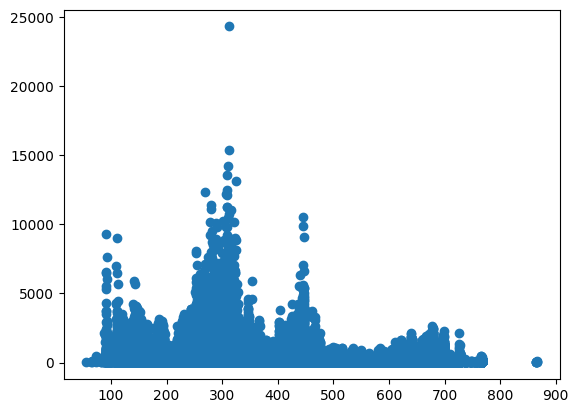

In [19]:
plt.scatter(train_data["base_price"], train_data["num_orders"])

<Axes: xlabel='base_price', ylabel='num_orders'>

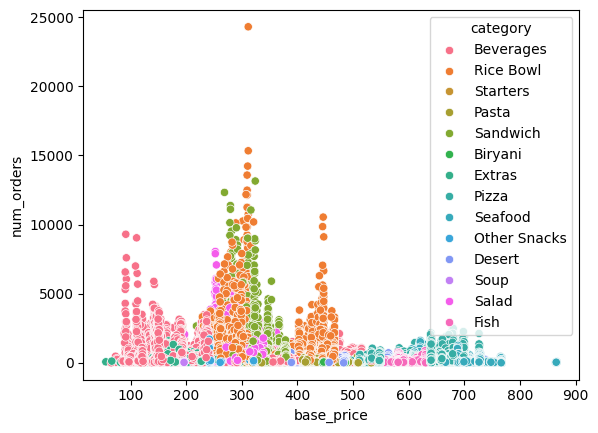

In [20]:
sns.scatterplot(x='base_price', y='num_orders', hue='category', data=train_data)

<Axes: xlabel='base_price', ylabel='num_orders'>

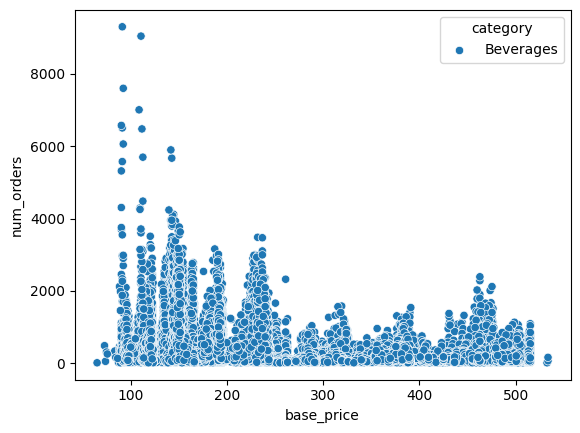

In [21]:
sns.scatterplot(x='base_price', y='num_orders', hue='category', data=train_data[train_data["category"] == "Beverages"])

In [22]:
train_data_beverages = train_data[train_data["category"] == "Beverages"]
test_data_beverages = test_data[test_data["category"] == "Beverages"]

In [65]:
from sklearn.linear_model import LinearRegression

x = train_data_beverages["base_price"].to_numpy().reshape(-1, 1)
y = train_data_beverages["num_orders"].to_numpy()

model = LinearRegression().fit(x, y)

In [66]:
x

array([[152.29],
       [135.83],
       [135.86],
       ...,
       [367.63],
       [369.63],
       [355.99]])

In [25]:
y

array([177, 270, 189, ...,  96, 136,  69])

In [28]:
model.__dict__

{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'n_features_in_': 1,
 'coef_': array([-0.96807654]),
 'rank_': 1,
 'singular_': array([36934.4513233]),
 'intercept_': 536.5377173336856}

In [ ]:
model.coef_, model.intercept_

In [29]:
train_data_beverages["predictions"] = model.predict(x)

In [30]:
train_data_beverages

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,predictions
0,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,389.109340
1,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,405.043880
2,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,405.014838
3,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,112.975187
4,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,301.779155
...,...,...,...,...,...,...,...,...,...,...,...
453245,144,61,1062,153.26,155.26,0,0,472,Beverages,Italian,386.234153
453246,144,61,2707,203.76,235.74,0,0,392,Beverages,Italian,308.323353
453247,144,61,1207,368.63,367.63,0,0,96,Beverages,Continental,180.643737
453248,144,61,1230,368.63,369.63,0,0,136,Beverages,Continental,178.707584


<Axes: xlabel='base_price', ylabel='num_orders'>

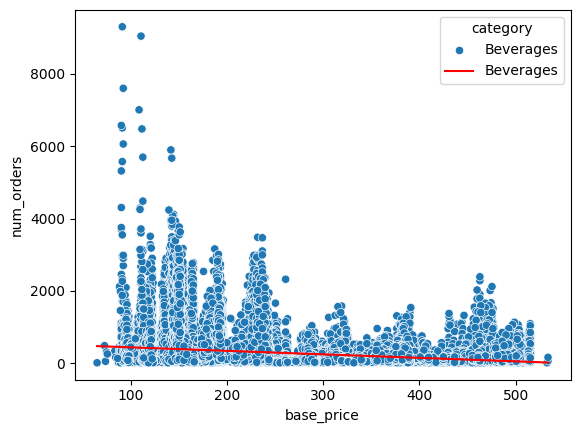

In [31]:
sns.scatterplot(x='base_price', y='num_orders', hue='category', data=train_data_beverages)
sns.lineplot(data=train_data_beverages, x='base_price', y='predictions', hue="category", palette=['red'])

<Axes: xlabel='base_price', ylabel='num_orders'>

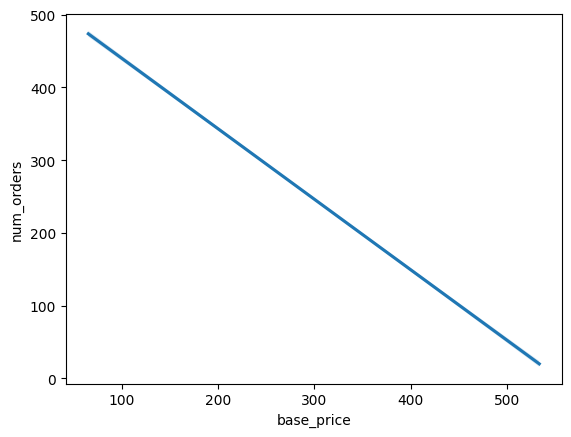

In [32]:
sns.regplot(data=train_data_beverages, x='base_price', y='num_orders', scatter=False)

In [33]:
from sklearn.metrics import mean_squared_error, r2_score
# MSE
# mean_squared_error = np.sum((y - y_hat.T)**2) / len(y)

test_data_beverages["predictions"] = model.predict(test_data_beverages["base_price"].to_numpy().reshape(-1, 1))

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(test_data_beverages["num_orders"], test_data_beverages["predictions"]))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(test_data_beverages["num_orders"], test_data_beverages["predictions"]))

Mean squared error: 96257.36
Coefficient of determination: 0.02


In [34]:
x_f = np.array([[1], [2], [3]])
y_f = np.array([1, 2, 3])

model_f = LinearRegression().fit(x_f, y_f)
model_f.coef_ = np.array([1.0])
model_f.intercept_ = np.array([0.0])


In [35]:
model_f.__dict__

{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'n_features_in_': 1,
 'coef_': array([1.]),
 'rank_': 1,
 'singular_': array([1.41421356]),
 'intercept_': array([0.])}

In [36]:
x_f = np.array([[1], [2], [3]])
y_hat = model_f.intercept_ + x_f*model_f.coef_

In [37]:
y_hat

array([[1.],
       [2.],
       [3.]])

In [38]:
mean_squared_error_manual = np.sum((y_f - y_hat.T)**2) / len(y_f)
mean_squared_error_manual

0.0

<Axes: xlabel='base_price', ylabel='num_orders'>

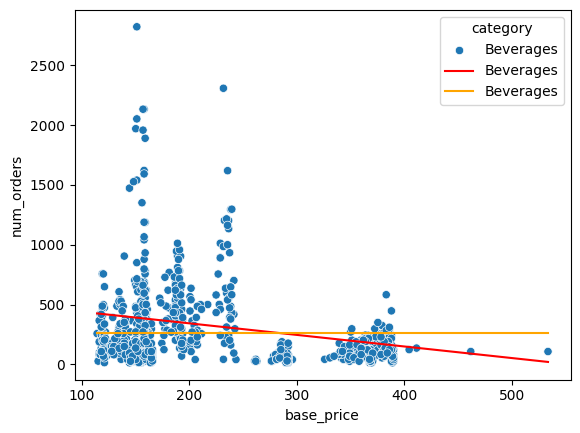

In [39]:
sns.scatterplot(x='base_price', y='num_orders', hue='category', data=test_data_beverages)
sns.lineplot(data=test_data_beverages, x='base_price', y='predictions', hue="category", palette=['red'])
sns.lineplot(data=test_data_beverages, x='base_price', y=test_data_beverages['num_orders'].mean(), hue="category", palette=['orange'])

In [46]:
mean = test_data_beverages['num_orders'].mean()
mean = np.array([[262]*len(test_data_beverages["num_orders"])])
mean_squared_error(test_data_beverages["num_orders"], mean.reshape(-1, 1))

# 96257.36

97973.82497212933

In [47]:
from copy import deepcopy

model_copy = deepcopy(model)
model_copy.coef_

array([-0.96807654])

In [48]:
model_copy.coef_ = np.array([-0.99])

train_predictions_samples = train_data_beverages[["base_price", "num_orders"]]
train_predictions_samples["exp_best"] = train_data_beverages["predictions"]
train_predictions_samples["exp_0"] = model_copy.predict(x)

In [49]:
train_predictions_samples

,base_price,num_orders,exp_best,exp_0
0,152.29,177,389.109340,385.770617
1,135.83,270,405.043880,402.066017
2,135.86,189,405.014838,402.036317
3,437.53,54,112.975187,103.383017
4,242.50,40,301.779155,296.462717
...,...,...,...,...
453245,155.26,472,386.234153,382.830317
453246,235.74,392,308.323353,303.155117
453247,367.63,96,180.643737,172.584017
453248,369.63,136,178.707584,170.604017


<Axes: xlabel='base_price', ylabel='value'>

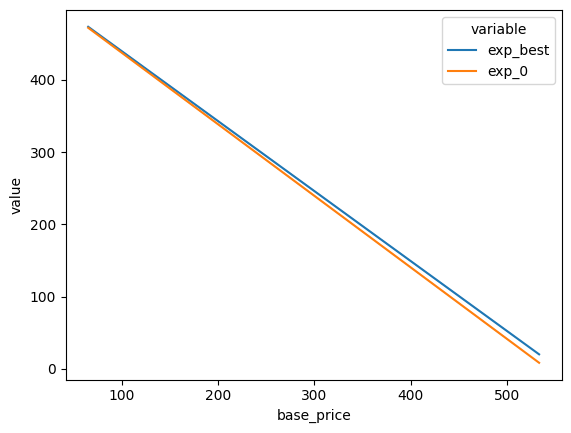

In [50]:
sns.lineplot(x='base_price', y='value', hue="variable", data=pd.melt(train_predictions_samples.drop(["num_orders"], axis=1), ['base_price']))

In [51]:
pd.melt(train_predictions_samples, ['base_price'])

,base_price,variable,value
0,152.29,num_orders,177.000000
1,135.83,num_orders,270.000000
2,135.86,num_orders,189.000000
3,437.53,num_orders,54.000000
4,242.50,num_orders,40.000000
...,...,...,...
380974,155.26,exp_0,382.830317
380975,235.74,exp_0,303.155117
380976,367.63,exp_0,172.584017
380977,369.63,exp_0,170.604017


In [52]:
coefs = [-4.2, -2.3, -1.7, -0.99, -0.98, -0.97, -0.84, -0.64, -0.5, -0.2, 0.01, 0.2, 0.45, 0.76, 0.99, 1.7, 2.3]

x_test = test_data_beverages["base_price"].to_numpy().reshape(-1, 1)
test_predictions_samples = test_data_beverages[["base_price", "num_orders"]]

models = []
for coef in coefs:
    new_model = deepcopy(model)
    new_model.coef_ = np.array([coef])
    models.append(new_model)

for i in range(len(models)):    
    test_predictions_samples[f"exp_{i}"] = models[i].predict(x_test)


In [53]:
test_predictions_samples

,base_price,num_orders,exp_0,exp_1,exp_2,exp_3,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,exp_14,exp_15,exp_16
453280,156.23,121,-119.628283,177.208717,270.946717,381.870017,383.432317,384.994617,405.304517,436.550517,458.422717,505.291717,538.100017,567.783717,606.841217,655.272517,691.205417,802.128717,895.866717
453281,158.14,54,-127.650283,172.815717,267.699717,379.979117,381.560517,383.141917,403.700117,435.328117,457.467717,504.909717,538.119117,568.165717,607.700717,656.724117,693.096317,805.375717,900.259717
453282,160.11,135,-135.924283,168.284717,264.350717,378.028817,379.629917,381.231017,402.045317,434.067317,456.482717,504.515717,538.138817,568.559717,608.587217,658.221317,695.046617,808.724717,904.790717
453283,292.03,15,-689.988283,-135.131283,40.086717,247.428017,250.348317,253.268617,291.232517,349.638517,390.522717,478.131717,539.458017,594.943717,667.951217,758.480517,825.647417,1032.988717,1208.206717
453284,165.93,96,-160.368283,154.898717,254.456717,372.267017,373.926317,375.585617,397.156517,430.342517,453.572717,503.351717,538.197017,569.723717,611.206217,662.644517,700.808417,818.618717,918.176717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456514,153.26,378,-107.154283,184.039717,275.995717,384.810317,386.342917,387.875517,407.799317,438.451317,459.907717,505.885717,538.070317,567.189717,605.504717,653.015317,688.265117,797.079717,889.035717
456515,234.74,312,-449.370283,-3.364283,137.479717,304.145117,306.492517,308.839917,339.356117,386.304117,419.167717,489.589717,538.885117,583.485717,642.170717,714.940117,768.930317,935.595717,1076.439717
456516,359.87,134,-974.916283,-291.163283,-75.241283,180.266417,183.865117,187.463817,234.246917,306.220917,356.602717,464.563717,540.136417,608.511717,698.479217,810.038917,892.809017,1148.316717,1364.238717
456517,367.63,42,-1007.508283,-309.011283,-88.433283,172.584017,176.260317,179.936617,227.728517,301.254517,352.722717,463.011717,540.214017,610.063717,701.971217,815.936517,900.491417,1161.508717,1382.086717


<Axes: xlabel='base_price', ylabel='value'>

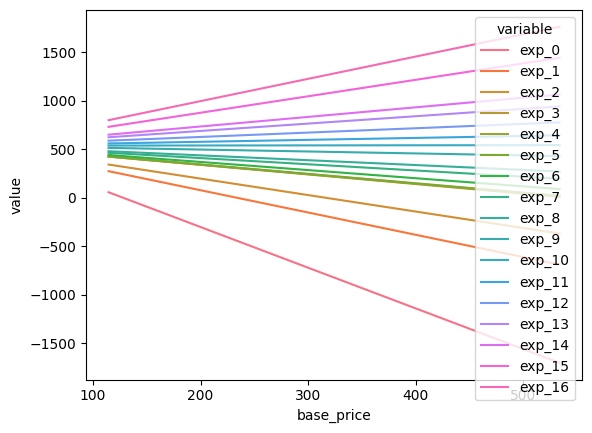

In [54]:
sns.lineplot(x='base_price', y='value', hue="variable", data=pd.melt(test_predictions_samples.drop(["num_orders"], axis=1), ['base_price']))

In [55]:
losses = []
for i, model in enumerate(models):
    losses.append(mean_squared_error(test_data_beverages["num_orders"], test_predictions_samples[f"exp_{i}"]))

In [56]:
losses

[645311.1514756285,
 172218.5195875937,
 111915.59958404078,
 95801.83089575155,
 96002.53122266047,
 96215.11084999933,
 100059.66234452503,
 109894.52609335454,
 119606.20421985132,
 148257.2813460782,
 174674.40071464828,
 203089.73811624022,
 247011.95519688498,
 311786.7371500374,
 367222.49190805363,
 577991.4821304181,
 802791.7724444572]

In [57]:
coefs

[-4.2,
 -2.3,
 -1.7,
 -0.99,
 -0.98,
 -0.97,
 -0.84,
 -0.64,
 -0.5,
 -0.2,
 0.01,
 0.2,
 0.45,
 0.76,
 0.99,
 1.7,
 2.3]

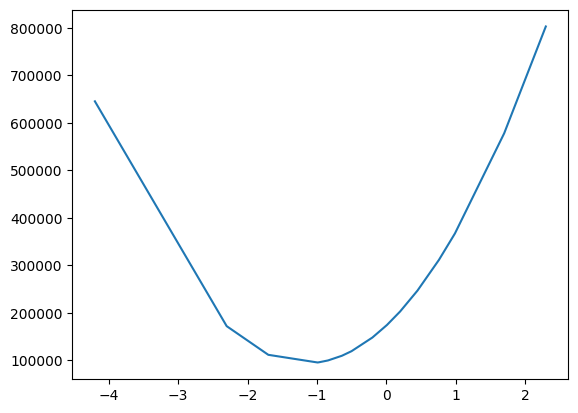

In [58]:
plt.plot(np.array(coefs), np.array(losses), label='MSE')

In [59]:
from sklearn import preprocessing
from copy import deepcopy

X_train = deepcopy(x)
scaler = preprocessing.StandardScaler().fit(X_train)
scaler.mean_, scaler.scale_


(array([226.86952793]), array([103.64342599]))

In [61]:
x

array([[152.29],
       [135.83],
       [135.86],
       ...,
       [367.63],
       [369.63],
       [355.99]])

In [60]:
X_scaled = scaler.transform(X_train)
X_scaled

array([[-0.71957799],
       [-0.87839173],
       [-0.87810227],
       ...,
       [ 1.35812253],
       [ 1.37741946],
       [ 1.2458144 ]])

In [62]:
model_scaled = LinearRegression().fit(X_scaled, y)

In [68]:
model_scaled.__dict__

{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'n_features_in_': 1,
 'coef_': array([-100.33476972]),
 'rank_': 1,
 'singular_': array([356.36077225]),
 'intercept_': 316.9106486184278}

In [67]:
model.__dict__

{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'n_features_in_': 1,
 'coef_': array([-0.96807654]),
 'rank_': 1,
 'singular_': array([36934.4513233]),
 'intercept_': 536.5377173336856}

In [75]:
test_data_beverages["base_price"].to_numpy().reshape(-1, 1)

array([[156.23],
       [158.14],
       [160.11],
       [292.03],
       [165.93],
       [162.02],
       [195.03],
       [193.03],
       [238.65],
       [388.  ],
       [381.27],
       [386.09],
       [159.11],
       [160.11],
       [160.11],
       [285.21],
       [192.12],
       [191.09],
       [228.95],
       [371.57],
       [377.36],
       [378.3 ],
       [158.14],
       [157.14],
       [158.11],
       [289.12],
       [163.93],
       [164.93],
       [181.45],
       [177.51],
       [236.71],
       [375.39],
       [364.75],
       [369.6 ],
       [139.71],
       [133.92],
       [134.86],
       [292.03],
       [148.47],
       [148.44],
       [153.29],
       [156.17],
       [228.01],
       [365.72],
       [363.75],
       [365.72],
       [118.37],
       [118.34],
       [119.31],
       [288.15],
       [153.32],
       [155.26],
       [155.23],
       [155.2 ],
       [202.73],
       [367.63],
       [369.63],
       [356.96],
       [151.38

In [76]:
from sklearn.metrics import mean_squared_error

test_data_beverages["predictions_normed"] = model_scaled.predict(test_data_beverages["base_price"].to_numpy().reshape(-1, 1))
mean_squared_error(test_data_beverages["num_orders"], test_data_beverages["predictions_normed"])

594200437.792277

In [77]:
# add second feature
X = train_data_beverages[["base_price", "emailer_for_promotion"]].to_numpy()
y = train_data_beverages["num_orders"].to_numpy()

model = LinearRegression().fit(X, y)

In [78]:
model.__dict__

{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'n_features_in_': 2,
 'coef_': array([ -0.9848209 , 165.24619166]),
 'rank_': 2,
 'singular_': array([36934.45151292,    78.52872345]),
 'intercept_': 531.8590335103219}

In [79]:
from sklearn.metrics import mean_squared_error

test_data_beverages["predictions"] = model.predict(test_data_beverages[["base_price", "emailer_for_promotion"]].to_numpy())
mean_squared_error(test_data_beverages["num_orders"], test_data_beverages["predictions"])

99182.99929421378

In [ ]:
# before that:
# 96257.50